### Another version of univariate analysis and forecasting
- using more of statsmodel built-in functionality rather than custom written functions. This version should run faster than v1 and has fancier visualisations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from itertools import product
%matplotlib inline

In [8]:
fire_data = pd.read_csv('dataset/amazon.csv',encoding='latin1')

In [9]:
# check if there is invalid data value in the dataframe
fire_data.isnull().sum()

year      0
state     0
month     0
number    0
date      0
dtype: int64

In [10]:
gb=fire_data.groupby('state')
states_df = [gb.get_group(x) for x in gb.groups]
print(len(states_df))
# Pick one state to do the forecasting
target_df= states_df[2]
# drop unwanted columns
target_df = target_df.loc[:, ['year', 'state','month','number']]

23


In [11]:
# Create the month mapping from latin to numbers
month_keys = set(target_df['month'])
# print(month_keys)
month_dict={
    'Março': 3, 
    'Junho': 6, 
    'Abril': 4, 
    'Setembro': 9,
    'Fevereiro': 2, 
    'Agosto': 8,
    'Maio': 5,
    'Novembro': 11,
    'Janeiro':1, 
    'Julho': 7,
    'Dezembro': 12,
    'Outubro':10
}
# convert month to sortabke numerical values
target_df['month'] = target_df['month'].apply(lambda x: month_dict[x])

In [12]:
# Prepare the dataset
target_df['day']=1
target_df.index=pd.DatetimeIndex(pd.to_datetime(target_df[['year', 'month','day']]))
target_df.sort_index(inplace=True,ascending=True)
target_df = target_df.loc[:, ['number']] # drop all irrelavant columns
target_df.tail()

,number
2017-07-01,3.0
2017-08-01,33.0
2017-09-01,95.0
2017-10-01,468.0
2017-11-01,858.0


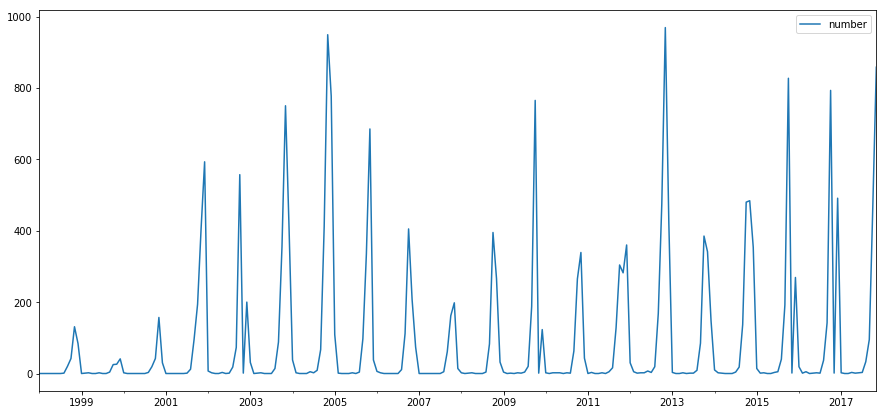

In [13]:
# plot the entire TS
fig, ax = plt.subplots(figsize=(15,7))
target_df.plot(y='number',ax=ax)

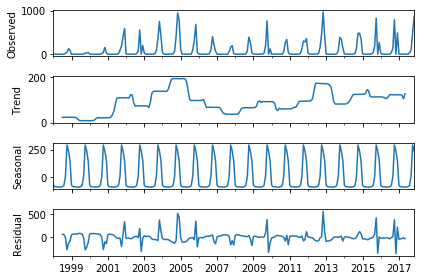

In [14]:
# Decompose the TS
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(target_df.number, model='additive')
result.plot()
plt.show()

Observations so far:
1. Data is discrete Time Series with evenly distributed samples over time (once per month)
2. No obvious trend maybe a little upward observed
3. Clear cyclic pattern or seasonality observed
4. No missing data observed
Let's start with traditional stats model. AR, MA ot ARMA models cannot handle seasonality or trend very well. 
ARIMA handles trend but not seasonality, so I will go with SARIMA to approach this problem. Plus you can always tweek the parameters of SARIMA to make it ARIMA, ARMA, AR or MA models.

In [58]:

p = q = range(0, 3)
d = range(0,2)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]
print(len(pdq))
print(len(seasonal_pdq))

18
18


### Compare out-of-sample prediction errors of different models, and select the model with the lowest AIC.

In [59]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from warnings import catch_warnings
from warnings import filterwarnings
best_aic=2**20
best_cfg=None
for param in pdq:
    for param_seasonal in seasonal_pdq:
#         try:
        with catch_warnings():
            filterwarnings("ignore")
            mod = SARIMAX(target_df.number,
                        order=param,
                        seasonal_order=param_seasonal,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
            results = mod.fit()

        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        if results.aic<best_aic:
            best_aic=results.aic
            best_cfg = 'Config {}x{}'.format(param, param_seasonal)
#             print('Model improved with config {}x{}'.format(param, param_seasonal))

#         except:
#             continue
print('Best Model {} yields AIC: {}'.format(best_cfg, best_aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:3227.86483071414
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:2987.9564464892387
ARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:2815.942502054533
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:2936.4571415023506
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:2737.8144921559624
ARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:2585.001528399045
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:2927.608052684347
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:2878.444287871105
ARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:2725.702194198535
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:2778.9201825203036
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:2729.5126621007335
ARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:2587.4641781126106
ARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:2772.579781204876
ARIMA(0, 0, 0)x(2, 0, 1, 12) - AIC:2739.8148910467335
ARIMA(0, 0, 0)x(2, 0, 2, 12) - AIC:2725.7862428715675
ARIMA(0, 0, 0)x(2, 1, 0, 12) - AIC:2623.3668884524604
ARIMA(0, 0, 0)x(2, 1, 1, 12) - AIC:2596.5347895339114
ARIMA(0, 0, 0)x(2, 1, 2, 12) - AIC:2587.377828986848
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:31

In [60]:
# The best option for config is SARIMA (0, 1, 2)x(2, 1, 2, 12)
with catch_warnings():
    filterwarnings("ignore")
    mod = SARIMAX(target_df.number,
                order=(0, 1, 2),
                seasonal_order=(2, 1, 2, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9780      0.130     -7.508      0.000      -1.233      -0.723
ma.L2         -0.0643      0.082     -0.783      0.434      -0.225       0.097
ar.S.L12       0.6199      0.132      4.700      0.000       0.361       0.878
ar.S.L24      -0.2380      0.052     -4.576      0.000      -0.340      -0.136
ma.S.L12      -1.5442      0.371     -4.167      0.000      -2.271      -0.818
ma.S.L24       0.5121      0.295      1.737      0.082      -0.066       1.090
sigma2      1.379e+04   4694.381      2.937      0.003    4585.854     2.3e+04


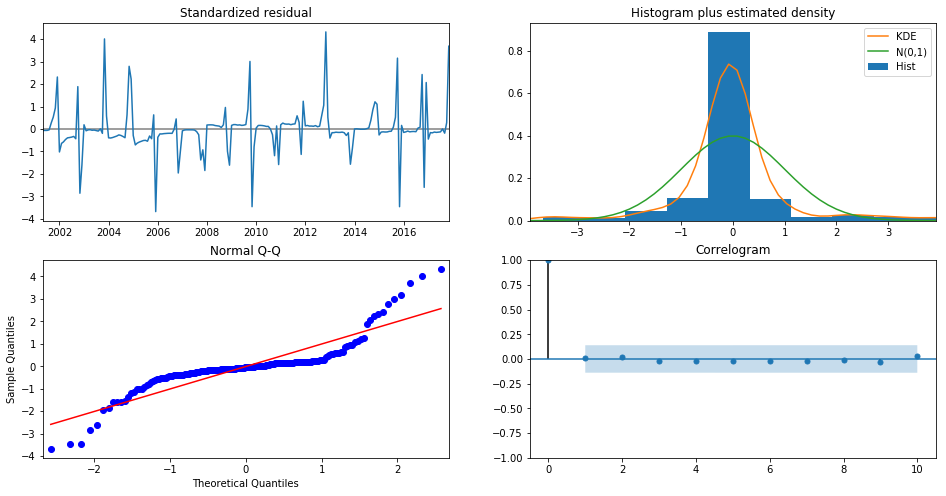

In [61]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [62]:
pred = results.get_prediction(start=pd.to_datetime('2013-12-01'), dynamic=False)

pred_ci = pred.conf_int()
# print(pred_ci)
target_df.head()

,number
1998-01-01,0.0
1998-02-01,0.0
1998-03-01,0.0
1998-04-01,0.0
1998-05-01,0.0


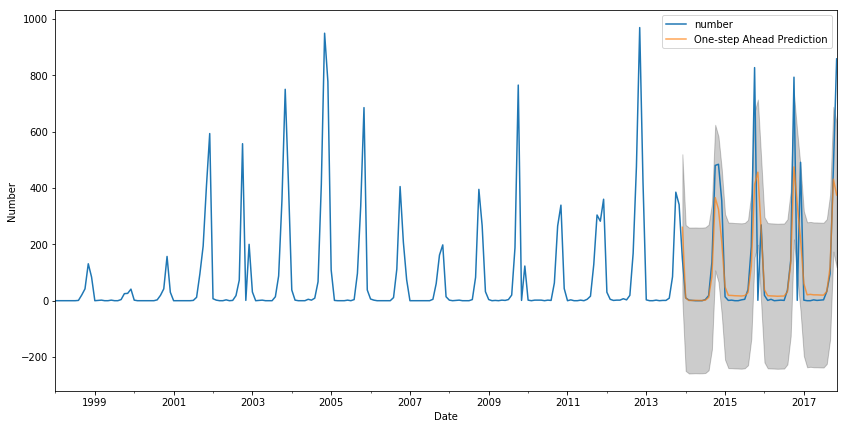

In [63]:
ax = target_df['1998':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Number')
plt.legend()
plt.show()

In [64]:
from math import sqrt
from sklearn.metrics import mean_squared_error
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [65]:
y_predicted = pred.predicted_mean
print(len(y_predicted))
y_truth = target_df['2013-12-01':]
print(len(y_truth))
mse = measure_rmse(y_truth, y_predicted)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

48
48
The Mean Squared Error of our forecasts is 144.04


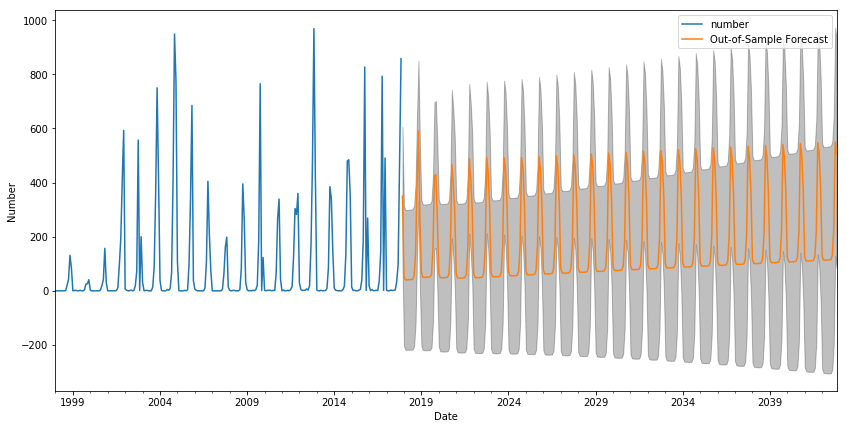

In [67]:
pred_uc = results.get_forecast(steps=300)
pred_ci = pred_uc.conf_int()
ax = target_df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Out-of-Sample Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Number')
plt.legend()
plt.show()